In [2]:
import osmnx as ox
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import shape

## Descarga de los grafos

In [ ]:
def get_walking_network(place_name: str):
    """
    Get the walking network for a specified place using OSMnx.

    Parameters:
        place_name (str): The name of the place to get the walking network for.

    Returns:
        graph: A directed graph representing the walking network.
    """
    graph = ox.graph_from_place(place_name, network_type="walk")

    return graph


def get_cycling_network(place_name: str):
    """
    Get the cycling network for a specified place using OSMnx.

    Parameters:
        place_name (str): The name of the place to get the cycling network for.

    Returns:
        graph: A directed graph representing the cycling network.
    """
    graph = ox.graph_from_place(
        place_name,
        network_type="bike",
        custom_filter='["highway"~"cycleway|footway|pedestrian"]',
    )

    return graph


walk_graph = get_walking_network("Valencia, Spain")
cycle_graph = get_cycling_network("Valencia, Spain")

# Save the graphs to files
ox.save_graphml(walk_graph, filepath="../data/valencia_walking_network.graphml")
ox.save_graphml(cycle_graph, filepath="../data/valencia_cycling_network.graphml")

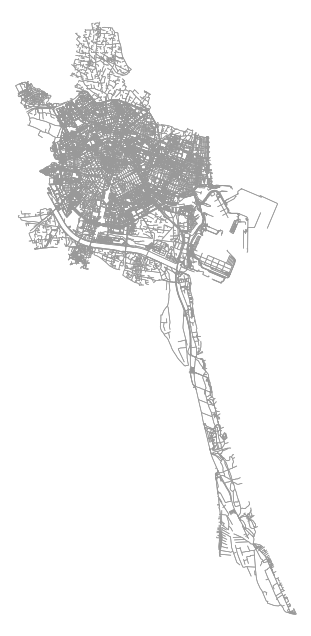

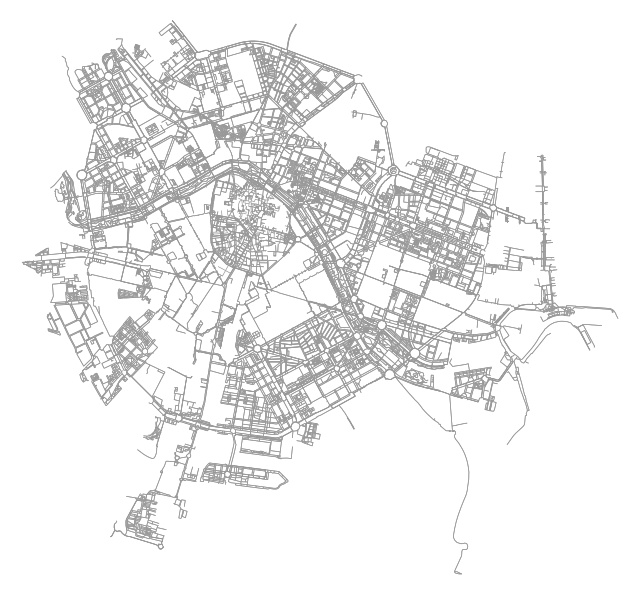

Text(0.5, 1.0, 'Cycling Network in Valencia, Spain')

In [3]:
# Load the saved graphs from files
walk_graph = ox.load_graphml("../data/valencia_walking_network.graphml")
cycle_graph = ox.load_graphml("../data/valencia_cycling_network.graphml")

# Pintar ambos grafos sobre un mapa, para ver que se corresponden bien las calles
fig_walk, ax_walk = ox.plot_graph(
    walk_graph, node_size=0, edge_linewidth=0.5, bgcolor="white"
)
ax_walk.set_title("Walking Network in Valencia, Spain")
fig_cycle, ax_cycle = ox.plot_graph(
    cycle_graph, node_size=0, edge_linewidth=0.5, bgcolor="white"
)
ax_cycle.set_title("Cycling Network in Valencia, Spain")

In [4]:
# convertir las aritas a GeoDataFrames para poder guardarlas como shapefiles

walk_edges = ox.graph_to_gdfs(walk_graph, nodes=False, edges=True)
cycle_edges = ox.graph_to_gdfs(cycle_graph, nodes=False, edges=True)

cycle_edges

osmid     highway  \
u           v           key                           
25767292    6766690060  0       5098789  pedestrian   
            35594380    0     583027084  pedestrian   
            5574601881  0     583027084  pedestrian   
            25767445    0     583027108  pedestrian   
25767297    525252743   0       5011436  pedestrian   
...                                 ...         ...   
12739547013 11794234787 0    1270239704     footway   
            12739547012 0    1375919971     footway   
12739551412 9749429924  0    1174302810     footway   
            9749429923  0    1174302810     footway   
            3419921570  0    1375920222     footway   

                                                            name  oneway  \
u           v           key                                                
25767292    6766690060  0             Carrer de Martínez Cubells   False   
            35594380    0                     Passeig de Russafa   False   
            5574601881  0                     Passeig de Russafa   False   
            25767445    0      Carrer del Convent de Santa Clara   False   
25767297    525252743   0    Carrer del Convent de Sant Francesc   False   
...                                                          ...     ...   
12739547013 11794234787 0                                    NaN   False   
            12739547012 0                                    NaN   False   
12739551412 9749429924  0                                    NaN   False   
            9749429923  0                                    NaN   False   
            3419921570  0                                    NaN   False   

                            reversed      length lanes maxspeed  \
u           v           key                                       
25767292    6766690060  0      False   56.652682   NaN      NaN   
            35594380    0      False   32.524900     1      NaN   
            5574601881  0       True  119.334932     1      NaN   
            25767445    0       True   53.048450   NaN      NaN   
25767297    525252743   0       True    4.870214   NaN      NaN   
...                              ...         ...   ...      ...   
12739547013 11794234787 0       True   38.596341   NaN      NaN   
            12739547012 0      False   44.589557   NaN      NaN   
12739551412 9749429924  0      False    8.139271   NaN      NaN   
            9749429923  0       True    5.840431   NaN      NaN   
            3419921570  0       True    6.898950   NaN      NaN   

                                                                      geometry  \
u           v           key                                                      
25767292    6766690060  0    LINESTRING (-0.37527 39.46829, -0.37461 39.46826)   
            35594380    0    LINESTRING (-0.37527 39.46829, -0.37534 39.46857)   
            5574601881  0    LINESTRING (-0.37527 39.46829, -0.37499 39.46724)   
            25767445    0     LINESTRING (-0.37527 39.46829, -0.37588 39.4683)   
25767297    525252743   0     LINESTRING (-0.37769 39.4695, -0.37769 39.46945)   
...                                                                        ...   
12739547013 11794234787 0     LINESTRING (-0.33866 39.45878, -0.3391 39.45883)   
            12739547012 0    LINESTRING (-0.33866 39.45878, -0.33873 39.45838)   
12739551412 9749429924  0     LINESTRING (-0.33428 39.44981, -0.3343 39.44973)   
            9749429923  0    LINESTRING (-0.33428 39.44981, -0.33427 39.44986)   
            3419921570  0    LINESTRING (-0.33428 39.44981, -0.33436 39.44982)   

                            area tunnel access  ref bridge width est_width  
u           v           key                                                 
25767292    6766690060  0    NaN    NaN    NaN  NaN    NaN   NaN       NaN  
            35594380    0    NaN    NaN    NaN  NaN    NaN   NaN       NaN  
            5574601881  0    NaN    NaN    NaN  NaN    NaN   NaN       NaN  
     

## Funtes de la ciudad

In [5]:
def get_valencian_open_data(url: str, params: dict = None):
    """
    Fetch open data from the Valencia City Council's open data portal.

    Returns:
        dict: A dictionary containing the fetched data.
    """
    df = pd.DataFrame()
    response = requests.get(url, params=params)

    if response.status_code == 200:
        total_records = response.json().get("total_count")
        print(f"Total records found: {total_records}")

        for start in range(0, total_records, params.get("rows", 10)):
            params["start"] = start
            response = requests.get(url, params=params)
            if response.status_code == 200:
                data = response.json()
                records = data.get("results", [])
                df = pd.concat([df, pd.DataFrame(records)], ignore_index=True)
            else:
                raise Exception(
                    f"Failed to fetch data: {response.status_code}\n{response.text}"
                )

        return df
    else:
        raise Exception(
            f"Failed to fetch data: {response.status_code}\n{response.text}"
        )


params = {
    "rows": 100,
}

url = "https://valencia.opendatasoft.com//api/explore/v2.1/catalog/datasets/fonts-daigua-publica-fuentes-de-agua-publica/records"
valencian_data = get_valencian_open_data(url, params)
valencian_data

Total records found: 832


,objectid,calle,codigo,foto,geo_shape,geo_point_2d
0,5,PASEO MARITIMO/HISTORIADOR COLOMA--2ª,1151,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3245649933146064, 'lat': 39.4703178..."
1,9,BULEVAR SUR - BARRACA AUSIAS MARCH 1,1040,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37167000776736375, 'lat': 39.445251..."
2,11,PLAZA DEL MERCADO,110,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37922498535436144, 'lat': 39.474571..."
3,17,JARDIN PLAZA DE LA REINA,104,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37553501058701816, 'lat': 39.474624..."
4,22,CEMENTERIO GENERAL SEC 20-1,C121,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3986200087544989, 'lat': 39.4429817..."
...,...,...,...,...,...,...
827,230,PLATERO SUAREZ /CALLE SAGUNTO,509,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.37407299938987454, 'lat': 39.485198..."
828,267,"AVDA. BLASCO IBAÑEZ, 96",1312,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.35000500025418557, 'lat': 39.474304..."
829,276,PLAZA JOAQUIN MUÑOZ PEIRATS 1,1607,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3951179978157639, 'lat': 39.4869956..."
830,150,PL DOCTOR LORENZO DE LA FLOR,1155,http://mapas.valencia.es/WebsMunicipales/layar...,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.33100999912996454, 'lat': 39.469399..."


In [6]:
valencian_data.to_csv("../data/fonts_publiques.csv", index=False)

## Estciones de ValenBisi

In [7]:
url = "https://valencia.opendatasoft.com//api/explore/v2.1/catalog/datasets/valenbisi-disponibilitat-valenbisi-dsiponibilidad/records"
valenbisi_data = get_valencian_open_data(url, params)
valenbisi_data

Total records found: 273


,address,number,open,available,free,total,ticket,updated_at,geo_shape,geo_point_2d,update_jcd
0,Xátiva - Bailén (Estación del Norte),17,T,26,2,30,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3772593951806123, 'lat': 39.4674683...",2025-06-12T18:58:48+00:00
1,Plaza España,58,T,8,12,20,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3815864106638383, 'lat': 39.4662183...",2025-06-12T18:54:30+00:00
2,Vicent Vidal - Pintor Maella,61,T,4,14,20,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.34783029886743094, 'lat': 39.461293...",2025-06-12T18:59:53+00:00
3,"Serrería, 67",84,T,12,2,15,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.33522597686590844, 'lat': 39.467123...",2025-06-12T18:56:28+00:00
4,Blasco Ibañez - Poeta Durán Tortajada,93,T,11,27,38,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.34380927742382206, 'lat': 39.472282...",2025-06-12T18:58:18+00:00
...,...,...,...,...,...,...,...,...,...,...,...
268,Ninot - Regino Mas,270,T,4,12,16,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.39288942312141745, 'lat': 39.500075...",2025-06-12T18:55:26+00:00
269,Vicente la Roda - Ingeniero Fausto Elio,272,T,11,4,15,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.33219023115385166, 'lat': 39.480623...",2025-06-12T18:59:14+00:00
270,Alcasser - Poeta Alberto Lista,265,T,6,9,15,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.40811749816977394, 'lat': 39.470973...",2025-06-12T18:55:54+00:00
271,Moraira - Alta del Mar,273,T,9,6,15,F,12/06/2025 19:00:24,"{'type': 'Feature', 'geometry': {'coordinates'...","{'lon': -0.3332722584595297, 'lat': 39.4503052...",2025-06-12T18:59:15+00:00


In [8]:
valenbisi_data.to_csv("../data/valenbisi_disponibilitat.csv", index=False)

In [9]:
valenbisi_data["geo_shape"][0]

{'type': 'Feature',
 'geometry': {'coordinates': [-0.3772593951806123, 39.46746831099193],
  'type': 'Point'},
 'properties': {}}

## Unión grafos con puntos valenbisi

In [10]:
def get_valenbisi_stations(valenbisi_data):
    """
    Extract Valenbisi stations from the Valenbisi data.

    Parameters:
        valenbisi_data (DataFrame): A DataFrame containing Valenbisi data.

    Returns:
        GeoDataFrame: A GeoDataFrame containing the Valenbisi stations.
    """

    # Convert the DataFrame to a GeoDataFrame
    gdf = gpd.GeoDataFrame(valenbisi_data, geometry=valenbisi_data["geometry"])
    gdf.set_crs(epsg=4326, inplace=True)  # Set the coordinate reference system

    return gdf


def get_nearest_cycle_station(graph, geovalenbisi):
    """
    Find the nearest point in the graph to each Valenbisi station.
    Parameters:
        graph: The cycling network graph.
        geovalenbisi (GeoDataFrame): A GeoDataFrame containing Valenbisi stations.
    Returns:
        GeoDataFrame: A GeoDataFrame with the nearest points in the graph to each Valenbisi station.
    """
    nearest_points = []
    for _, row in geovalenbisi.iterrows():
        point = row.geometry
        nearest_node = ox.distance.nearest_nodes(graph, point.x, point.y)
        nearest_points.append(nearest_node)

    geovalenbisi["nearest_node"] = nearest_points
    return geovalenbisi


valenbisi_data["geometry"] = valenbisi_data["geo_shape"].apply(shape)

geovalenbisi = get_valenbisi_stations(valenbisi_data)

geovalenbisi_cycle = get_nearest_cycle_station(cycle_graph, geovalenbisi)


# Save the GeoDataFrame to a file
geovalenbisi_cycle.to_file("../data/valenbisi_stations_cycle.geojson")

In [11]:
geovalenbisi_walk = get_nearest_cycle_station(walk_graph, geovalenbisi)
geovalenbisi_walk.to_file("../data/valenbisi_stations_walk.geojson")

## Edificios y árboles

In [12]:
edificios_data = gpd.read_file("../data/cartografia-base-edificis-edificios.geojson")
edificios_data

,objectid,elemento,creacion,fechacreac,escala,st_length_shape,geo_shape,geo_point_2d,geometry
0,38528,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,12.624459,None,"{ ""lon"": -0.38805989635242499, ""lat"": 39.45475...","LINESTRING (-0.38799 39.45473, -0.38799 39.454..."
1,38532,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,5.711177,None,"{ ""lon"": -0.38848326974559994, ""lat"": 39.45490...","LINESTRING (-0.38845 39.4549, -0.38846 39.4549..."
2,38535,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,6.810810,None,"{ ""lon"": -0.38868596120208387, ""lat"": 39.45499...","LINESTRING (-0.38865 39.45497, -0.38865 39.454..."
3,38537,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,7.810605,None,"{ ""lon"": -0.38882118633946117, ""lat"": 39.45506...","LINESTRING (-0.38878 39.45504, -0.38879 39.455..."
4,38543,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,16.792150,None,"{ ""lon"": -0.38760897322829674, ""lat"": 39.45499...","LINESTRING (-0.38752 39.45496, -0.38752 39.454..."
...,...,...,...,...,...,...,...,...,...
58219,40139,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,4.639050,None,"{ ""lon"": -0.2934582401529221, ""lat"": 39.305836...","LINESTRING (-0.29348 39.30582, -0.29344 39.30585)"
58220,40142,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,4.655308,None,"{ ""lon"": -0.29333076972772748, ""lat"": 39.30591...","LINESTRING (-0.29335 39.3059, -0.29331 39.30593)"
58221,40145,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,54.770402,None,"{ ""lon"": -0.30342623735823937, ""lat"": 39.31528...","LINESTRING (-0.30318 39.31513, -0.3032 39.3151..."
58222,40149,EDIFICIO,Restitucion fotogrametrica Vue,2018-08-01 02:00:00+00:00,500,0.027785,None,"{ ""lon"": -0.29882545051960852, ""lat"": 39.31234...","LINESTRING (-0.29883 39.31234, -0.29883 39.31234)"


In [18]:
edificios_data["geo_point_2d"][3]

'{ "lon": -0.38882118633946117, "lat": 39.455061260266554 }'

In [14]:
arboles_data = gpd.read_file("../data/arbratge-arbolado.geojson")
arboles_data

,objectid,ud_gestion,tipo_situacion,barrio,lugar,idarbol,nom_botanico,nom_comu_c,nom_comu_v,grupo,lpamcv,distrito,geo_point_2d,geometry
0,3881349,VSJS,Viario,125 - PENYA-ROJA,PINTOR MAELLA,58830/43,Gleditsia triacanthos,Acacia de tres espinas,Acàcia de tres espines,Caduco,SD,12 - CAMINS AL GRAU,"{ ""lon"": -0.34794863791906538, ""lat"": 39.45779...",POINT (-0.34795 39.45779)
1,3881351,VSJS,Viario,121 - AIORA,INDÚSTRIA,37050/133,Acer negundo,Arce negundo,Auró americà,Caduco,SD,12 - CAMINS AL GRAU,"{ ""lon"": -0.34251017196892003, ""lat"": 39.46656...",POINT (-0.34251 39.46656)
2,3881354,VSJS,Viario,123 - LA CREU DEL GRAU,EIVISSA,36690/72,Grevillea robusta,Roble australiano,Robre australià,Perenne,SD,12 - CAMINS AL GRAU,"{ ""lon"": -0.33980496026226609, ""lat"": 39.46123...",POINT (-0.3398 39.46124)
3,3881356,VSJS,Viario,121 - AIORA,PORT,25680/125,Ficus microcarpa,Laurel de Indias,Llorer d'Índies,Perenne,SD,12 - CAMINS AL GRAU,"{ ""lon"": -0.34213280110589772, ""lat"": 39.46290...",POINT (-0.34213 39.4629)
4,3881357,VSJS,Viario,044 - SANT PAU,ARTUR BALLESTER,81323/196,Firmiana simplex,Parasol chino/Firmiana,Firmiana,Caduco,SD,4 - CAMPANAR,"{ ""lon"": -0.40444305115843132, ""lat"": 39.48295...",POINT (-0.40444 39.48296)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159163,3920673,VSJS,Viario,16 - SANT FRANCESC,RIBERA,64230/14,Citrus aurantium,Naranjo amargo,Taronger bord,Perenne,SD,1 - CIUTAT VELLA,"{ ""lon"": -0.37590938973267418, ""lat"": 39.46772...",POINT (-0.37591 39.46773)
159164,3920772,VSJS,Viario,31 - EL BOTANIC,FERRAN EL CATÒLIC,30000/184,Citrus aurantium,Naranjo amargo,Taronger bord,Perenne,SD,3 - EXTRAMURS,"{ ""lon"": -0.38634117489589653, ""lat"": 39.47259...",POINT (-0.38634 39.47259)
159165,3920780,VSJS,Viario,34 - ARRANCAPINS,SANT VICENT MÀRTIR,69330/247,Citrus aurantium,Naranjo amargo,Taronger bord,Perenne,SD,3 - EXTRAMURS,"{ ""lon"": -0.3825757699130336, ""lat"": 39.459786...",POINT (-0.38258 39.45979)
159166,3920784,VSJS,Viario,34 - ARRANCAPINS,SANT VICENT MÀRTIR,69330/251,Citrus aurantium,Naranjo amargo,Taronger bord,Perenne,SD,3 - EXTRAMURS,"{ ""lon"": -0.38260153387455914, ""lat"": 39.45985...",POINT (-0.3826 39.45985)
